In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp

%matplotlib inline

In [33]:
# technical Terms:
# S = Susceptible
# E = exposed (incubation period)
# A = Asymptomatic (infected but not showing it)
# I = Infected
# R = Removed (recovered/deceased)
# R0 = Baseline infection rate for disease
# Rt = infection rate at time t (changes due to already infected population/actions)
# incubation_time = time person is not infectious (until symptoms start)
# disease_time = time person is symptomatic (until removed)
# symptom_rate = percent of people displaying symptoms

# Assumptions: 
#     Natural birth & death are not very important
#     Random encounters of people

def susceptible_change(S, A, I, E, R, contacts_asymptomatic, contacts_infected):
    return - S * (contacts_asymptomatic*A + contacts_infected*I) / (S+A+I+E+R)

def exposed_change(S, A, I, E, R, contacts_asymptomatic, contacts_infected, incubation_time):
    return (S * (contacts_asymptomatic*A + contacts_infected*I) / (S+A+I+E+R)) - (E / incubation_time)

def asymptomatic_change(A, I, E, incubation_time, disease_time, symptom_rate):
    return (1-symptom_rate) * (E / incubation_time) - (A / disease_time)

def infected_change(A, I, E, incubation_time, disease_time, symptom_rate):
    return symptom_rate * (E / incubation_time) - (I / disease_time)

def removed_change(I, A, disease_time):
    return ((I+A) / disease_time)

def SEIR_model(t, dynamics, contacts_asymptomatic, contacts_infected, incubation_time, disease_time, symptom_rate):    
    S, A, I, E, R = dynamics
    S_out = susceptible_change(S, A, I, E, R, contacts_asymptomatic, contacts_infected)
    A_out = asymptomatic_change(A, I, E, incubation_time, disease_time, symptom_rate)
    I_out = infected_change(A, I, E, incubation_time, disease_time, symptom_rate)
    E_out = exposed_change(S, A, I, E, R, contacts_asymptomatic, contacts_infected, incubation_time)
    R_out = removed_change(I, A, disease_time)
    return [S_out, A_out, I_out, E_out, R_out]

Example:

In [16]:
N = 100000  # Population size
n_infected = 1
max_days = 120

# State at time = 0 for SAIR model
a = (N - n_infected)/ N
b = 0
c = n_infected / N
d = 0.
e = 0.

In [11]:
def plot_model(solution, title='SAIR model'):
    sus, asympt, inf, exp, rec = solution.y

    f = plt.figure(figsize=(8,5)) 
    plt.plot(sus, 'b', label='Susceptible');
    plt.plot(exp, 'y', label='Exposed');
    plt.plot(inf, 'r', label='Infected');
    plt.plot(asympt, 'r+', label='Asymptomatic');
    plt.plot(rec, 'c', label='Recovered/deceased');
    plt.title(title)
    plt.xlabel("Days", fontsize=10);
    plt.ylabel("Fraction of population", fontsize=10);
    plt.legend(loc='best');

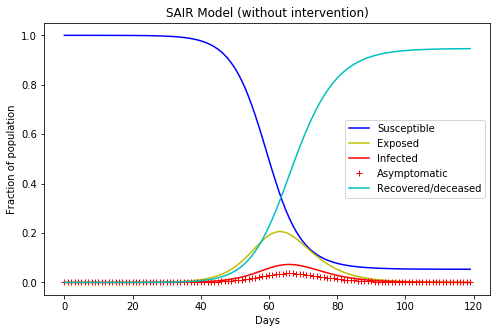

In [39]:
contacts_asymptomatic = 2.2
contacts_infected = 0.5
incubation_time = 5.2
disease_time = 2.9
symptom_rate = 0.666

sol = solve_ivp(SEIR_model, [0, max_days], [a, b, c, d, e], 
                args=(contacts_asymptomatic, contacts_infected, incubation_time, disease_time, symptom_rate), 
                t_eval=np.arange(max_days))

plot_model(sol, 'SEIR Model with asymptomatics (without intervention)')

In [42]:
# Now with intervention - contacts are time-dependant
def SEIR_model_intervention(t, dynamics, contacts_asymptomatic, contacts_infected, incubation_time, disease_time, symptom_rate):    
    S, A, I, E, R = dynamics
    contacts_A = contacts_asymptomatic(t)
    contacts_I = contacts_infected(t)
    
    S_out = susceptible_change(S, A, I, E, R, contacts_A, contacts_I)
    A_out = asymptomatic_change(A, I, E, incubation_time, disease_time, symptom_rate)
    I_out = infected_change(A, I, E, incubation_time, disease_time, symptom_rate)
    E_out = exposed_change(S, A, I, E, R, contacts_A, contacts_I, incubation_time)
    R_out = removed_change(I, A, disease_time)
    return [S_out, A_out, I_out, E_out, R_out]

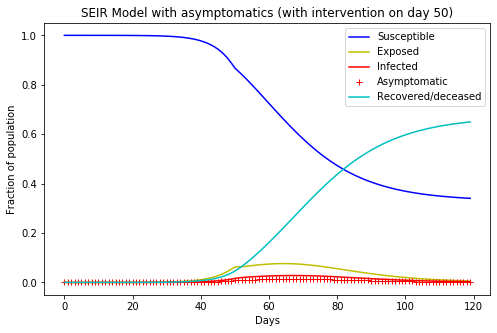

In [46]:
contacts_asymptomatic = 2.2
contacts_infected = 0.5
incubation_time = 5.2
disease_time = 2.9
symptom_rate = 0.666
intervention_day = 50

def contacts_I(t):
    if t < intervention_day:
        return contacts_infected
    else:
        return contacts_infected / 2
    
def contacts_A(t):
    if t < intervention_day:
        return contacts_asymptomatic
    else:
        return contacts_asymptomatic / 2

sol = solve_ivp(SEIR_model_intervention, [0, max_days], [a, b, c, d, e], 
                args=(contacts_A, contacts_I, incubation_time, disease_time, symptom_rate), 
                t_eval=np.arange(max_days))

plot_model(sol, f'SEIR Model with asymptomatics (with intervention on day {intervention_day})')